In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from OurPoincareEmbedding.pre_processing import preprocess

In [2]:
data=pd.read_csv("C:\\Users\\xiang\\OneDrive\\Documents\\M2R project\\GSE92332_AtlasFullLength_TPM.txt",sep="\t").T

In [4]:
adata = sc.AnnData(data)

# preprocess data

In [3]:
label=[x.split("_")[-1] for x in data.index]

adata = preprocess(data)

Number of cells after doublet removal: 1507


c:\Users\xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


Number of cells after quality control: 1415


In [10]:
Tuft1_signatures = ['Nradd', 'Gng13', 'Nrep', 'Rgs2', 'Pou2f3', 'Pou2f3']
Tuft2_signatures = ['Rac2', 'Ptgs1', 'Irf7','Ffar3','Alox5']
for i in Tuft1_signatures:
    print(f'{i} in variables: {i in adata.var_names}')
for j in Tuft2_signatures:
    print(f'{j} in variables: {j in adata.var_names}')

Nradd in variables: True
Gng13 in variables: True
Nrep in variables: True
Rgs2 in variables: True
Pou2f3 in variables: True
Pou2f3 in variables: True
Rac2 in variables: True
Ptgs1 in variables: True
Irf7 in variables: True
Ffar3 in variables: True
Alox5 in variables: True


In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

In [15]:
len(adata.var_names)

2000

In [16]:
for i in Tuft1_signatures:
    print(f'{i} in variables: {i in adata.var_names}')
for j in Tuft2_signatures:
    print(f'{j} in variables: {j in adata.var_names}')

Nradd in variables: False
Gng13 in variables: False
Nrep in variables: False
Rgs2 in variables: False
Pou2f3 in variables: False
Pou2f3 in variables: False
Rac2 in variables: False
Ptgs1 in variables: False
Irf7 in variables: False
Ffar3 in variables: False
Alox5 in variables: False


### PCA Embedding

In [ ]:
# sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color=['celltype'])

In [ ]:
# Access the PCA loadings
pca_loadings = adata.varm['PCs'][:, 0]  # Loadings for the first principal component

# Get the top contributing genes
top_genes_pca1 = pca_loadings.argsort()[-10:]  # Indices of top 10 contributing genes
top_genes_pca1_names = adata.var_names[top_genes_pca1]
print("Top genes contributing to PCA1:", top_genes_pca1_names)




In [ ]:
# Perform PCA
sc.tl.pca(adata)

# Access the PCA loadings
pca_loadings = adata.varm['PCs'][:, 0]  # Loadings for the first principal component

# Get the top contributing genes
# for PCA 1
top_genes_pca1 = pca_loadings.argsort()[-10:]  # Indices of top 10 contributing genes
top_genes_pca1_names = adata.var_names[top_genes_pca1]
print("Top genes contributing to PCA1:", top_genes_pca1_names)
# for PCA 2
pca_loadings_pca2 = adata.varm['PCs'][:, 1]
top_genes_pca2 = pca_loadings_pca2.argsort()[-10:]
# Get the names of the top 10 contributing genes for PCA2
top_genes_pca2_names = adata.var_names[top_genes_pca2]
print("Top genes contributing to PCA2:", top_genes_pca2_names)


### Hierarchical Clustering

In [ ]:
# reduce dimensions, only count for the most variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

##### Scipy

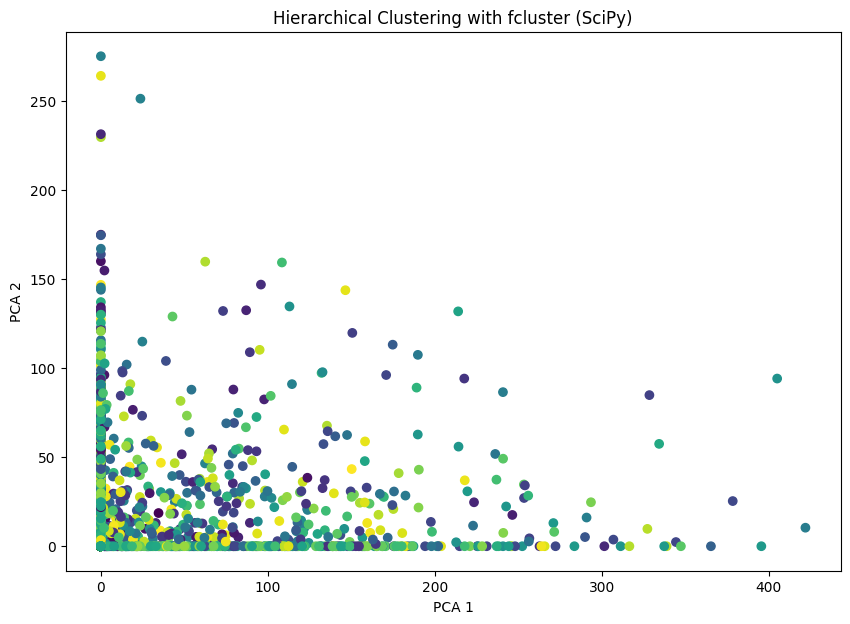

In [5]:
from scipy.cluster.hierarchy import linkage, fcluster


# Perform hierarchical clustering using the linkage function
Z = linkage(adata.X, method='ward')

# Get cluster labels
max_d = 0.5  # Distance threshold
clusters = fcluster(Z, max_d, criterion='distance')

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(adata.X[:, 0], adata.X[:, 1], c=clusters, cmap='viridis')
plt.title("Hierarchical Clustering with fcluster (SciPy)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


##### Sklearn

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Perform hierarchical clustering using AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
clustering.fit(adata.X)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(adata.X[:, 0], adata.X[:, 1], c=clustering.labels_, cmap='viridis')
plt.title("Agglomerative Clustering (scikit-learn)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

##### Seaborn

In [ ]:
import seaborn as sns
import pandas as pd

# Example data as a DataFrame
data = adata.X

# Create a clustermap
sns.clustermap(data, method='ward', cmap='viridis', standard_scale=1)
plt.title("Hierarchical Clustering Heatmap (seaborn)")
plt.show()


In [ ]:
def preprocess(data):
    ''' 
    Preprocess the data by performing dimensionality reduction, normalization, and quality control.
    Labels added to the data to enable supervised learning - accessed by adata.obs['celltype']
    Returns: adata - AnnData object with preprocessed data
    '''

    label=[x.split("_")[-1] for x in data.index]

    adata = sc.AnnData(data)
    adata.obs['celltype'] = label  # add the labels to the data to enable supervised learning

    # Preprocess the data
    sc.pp.filter_genes(adata, min_cells=5)  # Filter out lowly expressed genes

    # Doublet removal
    sc.pp.scrublet(adata, log_transform=True)
    adata = adata[adata.obs["predicted_doublet"] == False]
    print(f"Number of cells after doublet removal: {adata.n_obs}")   

    # Calculate quality control metrics
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    min_counts = np.percentile(adata.obs['total_counts'], 3) 
    adata = adata[adata.obs['total_counts'] > min_counts]
    max_counts = np.percentile(adata.obs['total_counts'], 97)
    adata = adata[adata.obs['total_counts'] < max_counts]
    print(f"Number of cells after quality control: {adata.n_obs}")   


    # set the raw data before normalization
    adata.raw = adata

    # Gene quality control 
    sc.pp.filter_genes(adata, min_cells=5)  # Filter out lowly expressed genes
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")  # Select genes providing most of the variance - reduce dimensionality
    adata = adata[:, adata.var.highly_variable]
    print(f"Number of cells and genes after selecting highly variable genes: {adata.n_obs}, {adata.n_vars}")   


    # Normalize the total counts per cell
    sc.pp.normalize_total(adata, target_sum=1e4)

    # Log-transform the data
    sc.pp.log1p(adata)

    sc.pp.regress_out(adata, ["total_counts"]) # removes unnecessary influence of certain variables

    # scale data to unit variance and mean 0 - useful for machine learning
    sc.pp.scale(adata, max_value=10)

    # Dimensionality reduction later, depending on embedding

    return adata

if __name__ == "__main__":
    data = pd.read_csv("GSE92332_AtlasFullLength_TPM.txt",sep="\t").T
    adata = preprocess(data)

Number of cells after doublet removal: 1507


c:\Users\xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


Number of cells after quality control: 1415


c:\Users\xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of cells and genes after selecting highly variable genes: 1415, 2000


c:\Users\xiang\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
def dim_reducion(embedding):
    if embedding == 'pca':
        sc.tl.pca(adata, svd_solver='arpack')
        sc.pl.pca(adata, color=['celltype'])
    elif embedding == 'umap':
        sc.tl.umap(adata)
        sc.pl.umap(adata, color=['celltype'])
    elif embedding == 'tSNE':
        sc.tl.tsne(adata)
        sc.pl.tsne(adata, color=['celltype'])
    else:
        raise TypeError("Embedding method not registered")
    # reduce dimensions, only count for the most variable genes
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [ ]:
def plot_clusters(embedding):
    if embedding == 'pca':
        sc.pp.neighbors(adata, use_rep='X_pca')
        sc.tl.pca(adata)
        sc.pl.pca(adata, color='hierarchical_clusters', legend_loc='on data')
        plt.show()
    elif embedding == 'umap':
        sc.pp.neighbors(adata, use_rep='X_pca')
        sc.tl.umap(adata)
        sc.pl.umap(adata, color='hierarchical_clusters', legend_loc='on data')
        plt.show()
    elif embedding == 'tSNE':
        sc.pp.neighbors(adata, use_rep='X_tsne')
        sc.tl.tsne(adata)
        sc.pl.tsne(adata, color='hierarchical_clusters', legend_loc='on data')
    else:
        raise TypeError("Embedding method not registered")

def scipy_hierarchical_clustering(data, linkage_method, cluster_criterion, embedding):
    import scipy.cluster.hierarchy as hc
    from scipy.cluster.hierarchy import fcluster
    from scipy.spatial.distance import pdist
    
    # Compute the linkage matrix
    Z = hc.linkage(data, method=linkage_method)
    # Plot the dendrogram
    plt.figure(figsize=(10, 8))
    dendrogram = hc.dendrogram(Z)
    plt.title(f'Dendrogram by {linkage_method} linkage')
    plt.xlabel('Cell Types')
    plt.ylabel('Distance')
    plt.show()

    # Form clusters by cutting dendrogram
    if cluster_criterion == 'maxclust_monocrit':
        monocrit = pdist(data)
        clusters = fcluster(Z, t=11, criterion=cluster_criterion, monocrit=monocrit)
    else:
        clusters = fcluster(Z, t=11, criterion=cluster_criterion)
    adata.obs['hierarchical_clusters'] = clusters.astype(str)
    
    plot_clusters(embedding)


## Clustering and Evaluation

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances

In [10]:
def agglomerative_clustering(data, n_clusters=11):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = clustering.fit_predict(data)
    
    # Create dendrogram
    Z = linkage(data, 'ward')
    plt.figure(figsize=(10, 7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
    plt.show()
    
    return cluster_labels

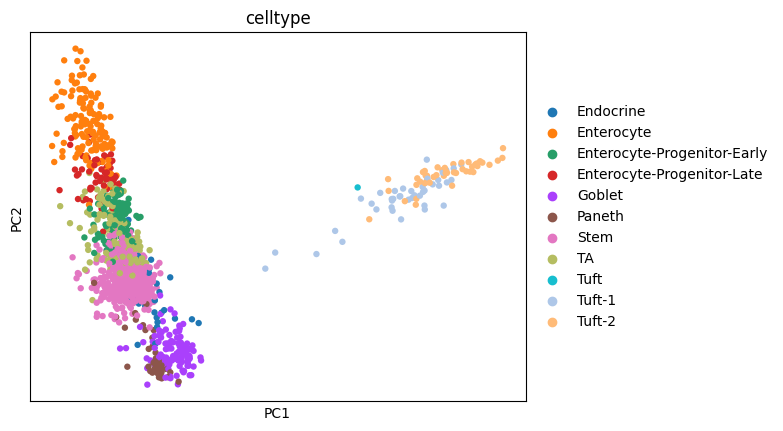

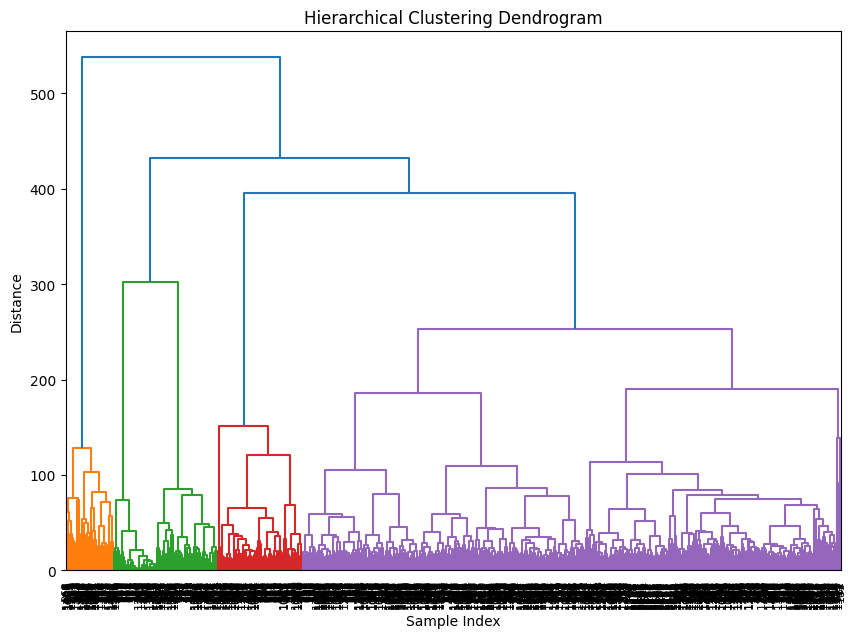

In [ ]:
dim_reducion('pca')
data = adata.obsm['X_pca']
pca_labels = agglomerative_clustering(data, n_clusters=11)

In [ ]:
sil_score = silhouette_score(adata.obsm['X_pca'], pca_labels, metric='euclidean')
db_index = davies_bouldin_score(adata.obsm['X_pca'], pca_labels)
print(f'Silhouette Score for Hierarchical clustering in Euclidean metric: {sil_score}')
print(f'Davies-Bouldin Index for Hierarchical clustering in Euclidean metric: {db_index}')

Silhouette Score for Hierarchical clustering in Euclidean metric: 0.15327781438827515
Davies-Bouldin Index for Hierarchical clustering in Euclidean metric: 2.5671662950526133


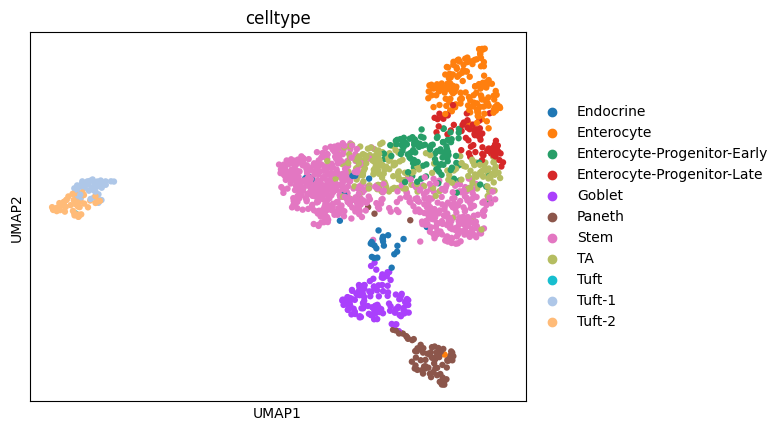

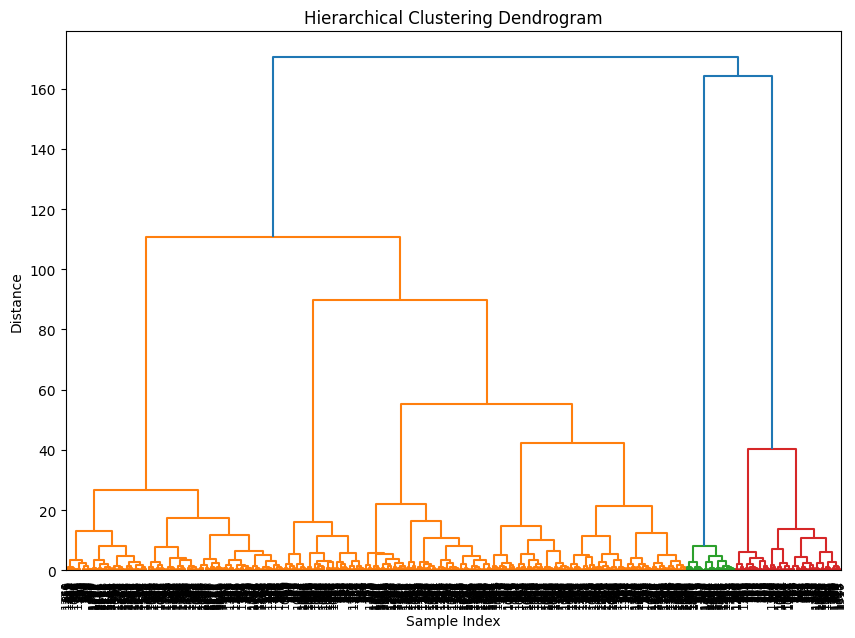

In [ ]:
dim_reducion('umap')
data = adata.obsm['X_umap']
umap_labels = agglomerative_clustering(data, n_clusters=11)

In [ ]:
sil_score = silhouette_score(adata.obsm['X_umap'], umap_labels, metric='euclidean')
db_index = davies_bouldin_score(adata.obsm['X_umap'], umap_labels)
print(f'Silhouette Score for Hierarchical clustering in Euclidean metric: {sil_score}')
print(f'Davies-Bouldin Index for Hierarchical clustering in Euclidean metric: {db_index}')

Silhouette Score for Hierarchical clustering in Euclidean metric: 0.4182931184768677
Davies-Bouldin Index for Hierarchical clustering in Euclidean metric: 0.7532589271909701


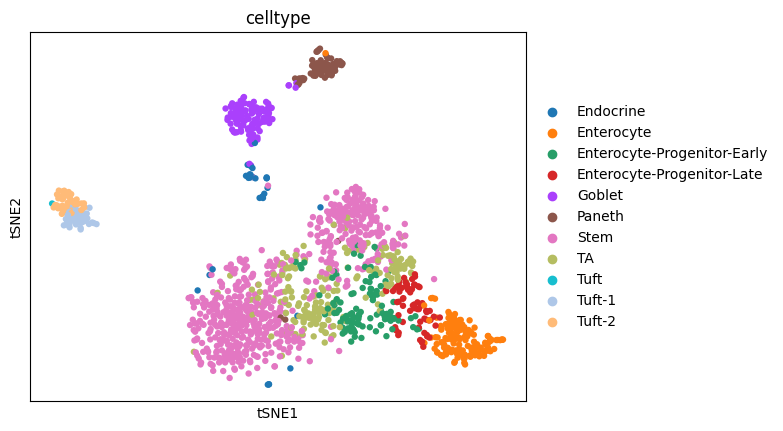

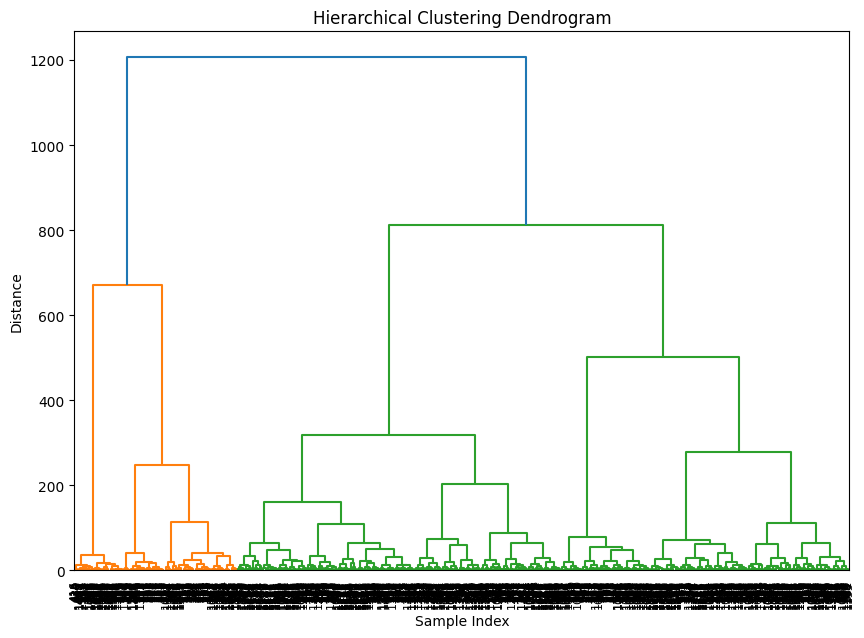

In [ ]:
dim_reducion('tSNE')
data = adata.obsm['X_tsne']
tsne_labels = agglomerative_clustering(data, n_clusters=11)

In [ ]:
sil_score = silhouette_score(adata.obsm['X_tsne'], tsne_labels, metric='euclidean')
db_index = davies_bouldin_score(adata.obsm['X_tsne'], tsne_labels)
print(f'Silhouette Score for Hierarchical clustering in Euclidean metric: {sil_score}')
print(f'Davies-Bouldin Index for Hierarchical clustering in Euclidean metric: {db_index}')

Silhouette Score for Hierarchical clustering in Euclidean metric: 0.48986807465553284
Davies-Bouldin Index for Hierarchical clustering in Euclidean metric: 0.647981886831751


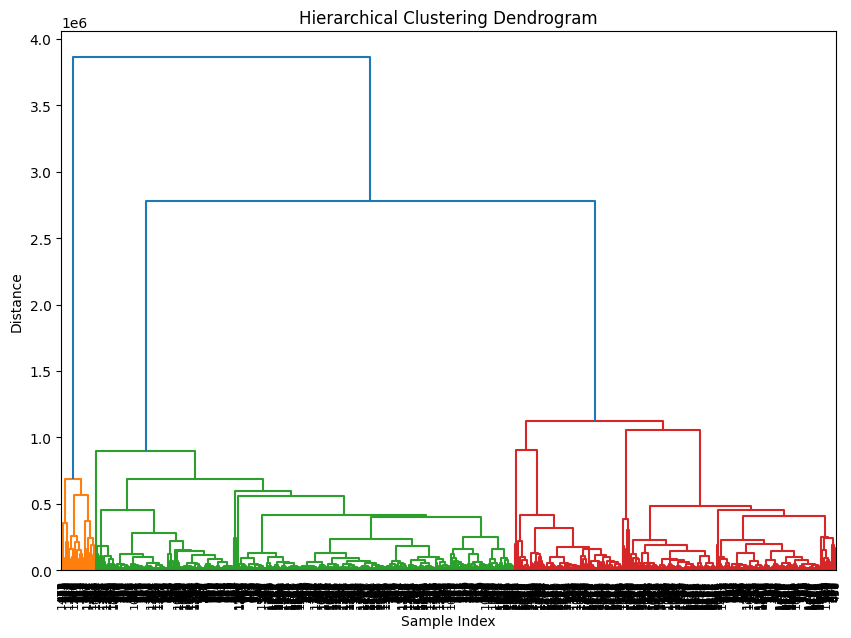

In [11]:
unprocessed_labels = agglomerative_clustering(adata.X, n_clusters=11)

In [9]:
sil_score = silhouette_score(adata.X, clusters, metric='euclidean')
db_index = davies_bouldin_score(adata.X, clusters)
print(f'Silhouette Score for Hierarchical clustering with unprocessed data: {sil_score}')
print(f'Davies-Bouldin Index for Hierarchical clustering with unprocessed data: {db_index}')

ValueError: Number of labels is 1522. Valid values are 2 to n_samples - 1 (inclusive)

## Experiments

In [ ]:
import itertools
method_grid = {
    'embedding': ['pca', 'umap'],
    'linkage_method': ['complete', 'weighted','centroid', 'ward'],
    'cluster_criterion': ['maxclust', 'maxclust_monocrit']
}

result_dict = {}
n = 0
m = 0

# Iterate over all combinations of hyperparameters
for params in itertools.product(*method_grid.values()):
    print(params)
    embedding, linkage_method, cluster_criterion = params
    data = adata.X
    if n < 1 and embedding == 'pca':
        dim_reducion(embedding)
        n += 1
    elif m < 1 and embedding == 'umap':
        dim_reducion(embedding)
        m += 1
    scipy_hierarchical_clustering(data, linkage_method, cluster_criterion, embedding)
    n += 1

### previous

In [ ]:
import scipy.cluster.hierarchy as hc


# Step 2: Compute the linkage matrix
Z = hc.linkage(X, method='complete')

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram = hc.dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Cell Types')
plt.ylabel('Distance')
plt.show()



In [ ]:
# Form clusters by cutting dendrogram
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, t=11, criterion='maxclust')
adata.obs['hierarchical_clusters'] = clusters.astype(str)


In [ ]:
adata.obs

In [ ]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color='hierarchical_clusters', legend_loc='on data')
plt.show()


In [ ]:
# Filter out clusters with less than 5 samples
cluster_counts = adata.obs['hierarchical_clusters'].value_counts()
large_clusters = cluster_counts[cluster_counts >= 5].index
adata_filtered = adata[adata.obs['hierarchical_clusters'].isin(large_clusters)].copy()


In [ ]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color='hierarchical_clusters', legend_loc='on data')
plt.show()

In [ ]:
# Find marker genes for prominent clusters
sc.tl.rank_genes_groups(adata_filtered, groupby='hierarchical_clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False)

In [ ]:
marker_genes = pd.DataFrame()
for group in adata_filtered.uns['rank_genes_groups']['names'].dtype.names:
    group_df = pd.DataFrame({
        'names': adata_filtered.uns['rank_genes_groups']['names'][group],
        'pvals': adata_filtered.uns['rank_genes_groups']['pvals'][group],
        'logfoldchanges': adata_filtered.uns['rank_genes_groups']['logfoldchanges'][group],
        'scores': adata_filtered.uns['rank_genes_groups']['scores'][group]
    })
    group_df['cluster'] = group
    marker_genes = pd.concat([marker_genes, group_df])

marker_genes

In [ ]:
marker_genes = marker_genes[marker_genes['pvals'] < 0.05]
marker_genes

In [ ]:
marker_genes_dict = {}
for cluster in marker_genes['cluster'].unique():
    marker_genes_dict[cluster] = marker_genes[marker_genes['cluster'] == cluster]['names'].tolist()

# Print the marker genes for each cluster
for cluster, genes in marker_genes_dict.items():
    print(f"Cluster {cluster}: {genes[:10]}\n")